[View in Colaboratory](https://colab.research.google.com/github/gamante91/pytorch_notebooks/blob/master/ConvNN_MNIST.ipynb)

In [30]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' #'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
print('Platform:', platform, 'Accelerator:', accelerator)

!pip install --upgrade torch
!pip install --upgrade torchvision

Platform: cp36-cp36m Accelerator: cu80
Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (0.4.1)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.2.1)


In [31]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', device)

Torch 0.4.1 CUDA 9.0.176
Device: cuda:0


In [0]:
# Hyper-parameter
batch_size = 100

# Load the MNIST dataset with torchvision 
train_dataset = torchvision.datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [0]:
# Hyper-parameters
num_epochs = 20
num_classes = 10
batch_size = 100
learning_rate = 0.001

In [0]:
# Define Convolutional Neural Network model
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [35]:
# Instanciate the model
model = ConvNet(num_classes).to(device)

print("Model description:\n", model)

Model description:
 ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


In [0]:
# Construct loss function and optimizer
criterion = nn.CrossEntropyLoss()                           # Cross Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Stochastic Gradient Descent

Epoch: 0 loss: 0.05155560001730919
Epoch: 1 loss: 0.054467249661684036
Epoch: 2 loss: 0.012793012894690037
Epoch: 3 loss: 0.08530494570732117
Epoch: 4 loss: 0.04401886835694313
Epoch: 5 loss: 0.008303243666887283
Epoch: 6 loss: 0.024211039766669273
Epoch: 7 loss: 0.0028443573974072933
Epoch: 8 loss: 0.002394263166934252
Epoch: 9 loss: 0.008879953995347023
Epoch: 10 loss: 0.003187580034136772
Epoch: 11 loss: 0.0011781537905335426
Epoch: 12 loss: 0.0050160945393145084
Epoch: 13 loss: 0.0011074519716203213
Epoch: 14 loss: 0.016137603670358658
Epoch: 15 loss: 0.00044471025466918945
Epoch: 16 loss: 0.010700857266783714
Epoch: 17 loss: 0.0016525005921721458
Epoch: 18 loss: 0.010068688541650772
Epoch: 19 loss: 0.0001672506332397461


Text(0.5,0,'epoch')

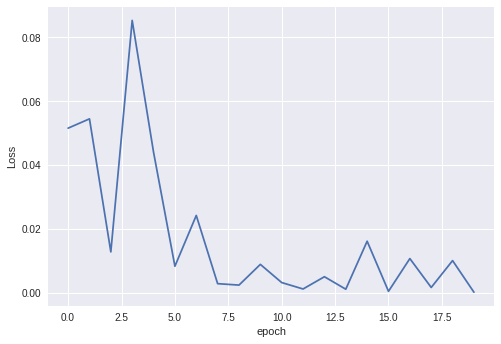

In [37]:
# Train the model
losses = []

# Train the model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Compute loss
        loss = criterion(outputs, labels)
    
        # Compute gradient and update model parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    losses.append(loss.item())
    print("Epoch:", epoch, "loss:", loss.item())

plt.plot(range(num_epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch')

In [45]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the ', len(train_dataset), ' train images: {} %'.format(100 * correct / total))
    
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the ', len(test_dataset), ' test images: {} %'.format(100 * correct / total))


Test Accuracy of the model on the  60000  train images: 99.81 %
Test Accuracy of the model on the  10000  test images: 99.09 %
